# Analysis of transcriptomic changes during Mz19 development: gene expression dynamics (Figure 6)

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
df_logCPM_all = pd.read_csv("../data/df_Mz19Development.csv.gz", header=0, index_col=0)
df_libs = pd.read_csv("../data/libs.csv", sep=",", header=0, index_col=0) # sample info

In [3]:
# Rename df for convenience
df = df_logCPM_all
X = df
X.drop(["roX1", "roX2"], inplace=True) # Drop uninformative genes

In [4]:
def load_list(infile):
    X = []
    with open(infile) as f:
        for line in f:
            X.append(line.rstrip())
    return X

CSMs = load_list("/local10G/rfhorns/FlyBrain/rnaseq/resources/CSMs.txt")
TFs = load_list("/local10G/rfhorns/FlyBrain/rnaseq/resources/TFs.txt")

# Load names of cells belonging to lineages and classes

In [5]:
names_adPN_all = load_list("../data/names_Mz19_adPN_all.txt")
names_lPN_all = load_list("../data/names_Mz19_lPN_all.txt")
names_adPN_VA1d = load_list("../data/names_Mz19_adPN_ClassB.txt")
names_adPN_DC3 = load_list("../data/names_Mz19_adPN_ClassA.txt")

In [7]:
# Load genes that are differentially expressed between 24h APF and adult

genes_DE_24hAPF_adult_24hAPFHigh = []
with open("../data/genes_DE_24hAPF_adult_24hAPFHigh.txt") as f:
    for line in f:
        genes_DE_24hAPF_adult_24hAPFHigh.append(line.rstrip())

genes_DE_24hAPF_adult_adultHigh = []
with open("../data/genes_DE_24hAPF_adult_adultHigh.txt") as f:
    for line in f:
        genes_DE_24hAPF_adult_adultHigh.append(line.rstrip())

# Calculate median expression of each gene at each time point


In [8]:
def calc_median_for_timepoints(df, df_libs):
    # Calculates median expression of each gene for each time point
    labels = [("24hAPF", "Mz19-GFP,24hAPF"), ("36hAPF", "Mz19-GFP,36hAPF"), ("48hAPF", "Mz19-GFP,48hAPF"),
              ("72hAPF", "Mz19-GFP,72hAPF"), ("adult", "Mz19-GFP,adult")]
    df_aggr = pd.DataFrame()
    for name, label in labels:
        df_aggr[name] = np.median(df.T.loc[df_libs.loc[df.columns]["label"] == label].T, axis=1)
    df_aggr.index = df.index
    return df_aggr

In [9]:
df_timepoints_median = calc_median_for_timepoints(df, df_libs)

# Cluster dynamical profiles using TSNE/HDBSCAN

In [13]:
# Filter for genes that are expressed in at least 3 cells
df_filtered = df.loc[np.sum(df > 2.0, axis=1) > 3]
print df_filtered.shape

# Filter genes for those expressed highly in at least one time point
# X = df_timepoints_median.loc[np.sum(df_timepoints_median > 8, axis=1) > 0]
X = df_timepoints_median

# Normalize expression of each gene to itself (scales expression at each timepoint between 0 and 1)
X = X.div(X.max(axis=1), axis=0)

# Filter for genes with substantial variation across time
# X = X.loc[np.std(X, axis=1) >= 0.05]

# Filter for genes that are DE between 24h APF and adult
X = X.loc[genes_DE_24hAPF_adult_24hAPFHigh+genes_DE_24hAPF_adult_adultHigh]

# Drop rows with NaN
X.dropna(inplace=True)

print X.shape

(8940, 485)
(1070, 5)


In [14]:
from sklearn.manifold import TSNE
myTSNE = TSNE(n_components=2, metric="correlation",
              perplexity=20, early_exaggeration=6.0,
              learning_rate=1000, verbose=2)
X_TSNE = myTSNE.fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1070
[t-SNE] Computed conditional probabilities for sample 1070 / 1070
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.2892210, gradient norm = 0.0080503
[t-SNE] Iteration 50: error = 1.1636569, gradient norm = 0.0092286
[t-SNE] Iteration 75: error = 0.7942015, gradient norm = 0.0023605
[t-SNE] Iteration 100: error = 0.7629099, gradient norm = 0.0051641
[t-SNE] Error after 100 iterations with early exaggeration: 0.762910
[t-SNE] Iteration 125: error = 0.6921681, gradient norm = 0.0013143
[t-SNE] Iteration 150: error = 0.6796095, gradient norm = 0.0031647
[t-SNE] Iteration 175: error = 0.6836475, gradient norm = 0.0044961
[t-SNE] Iteration 200: error = 0.6864594, gradient norm = 0.0052624
[t-SNE] Iteration 200: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 200 iterations: 0.686459


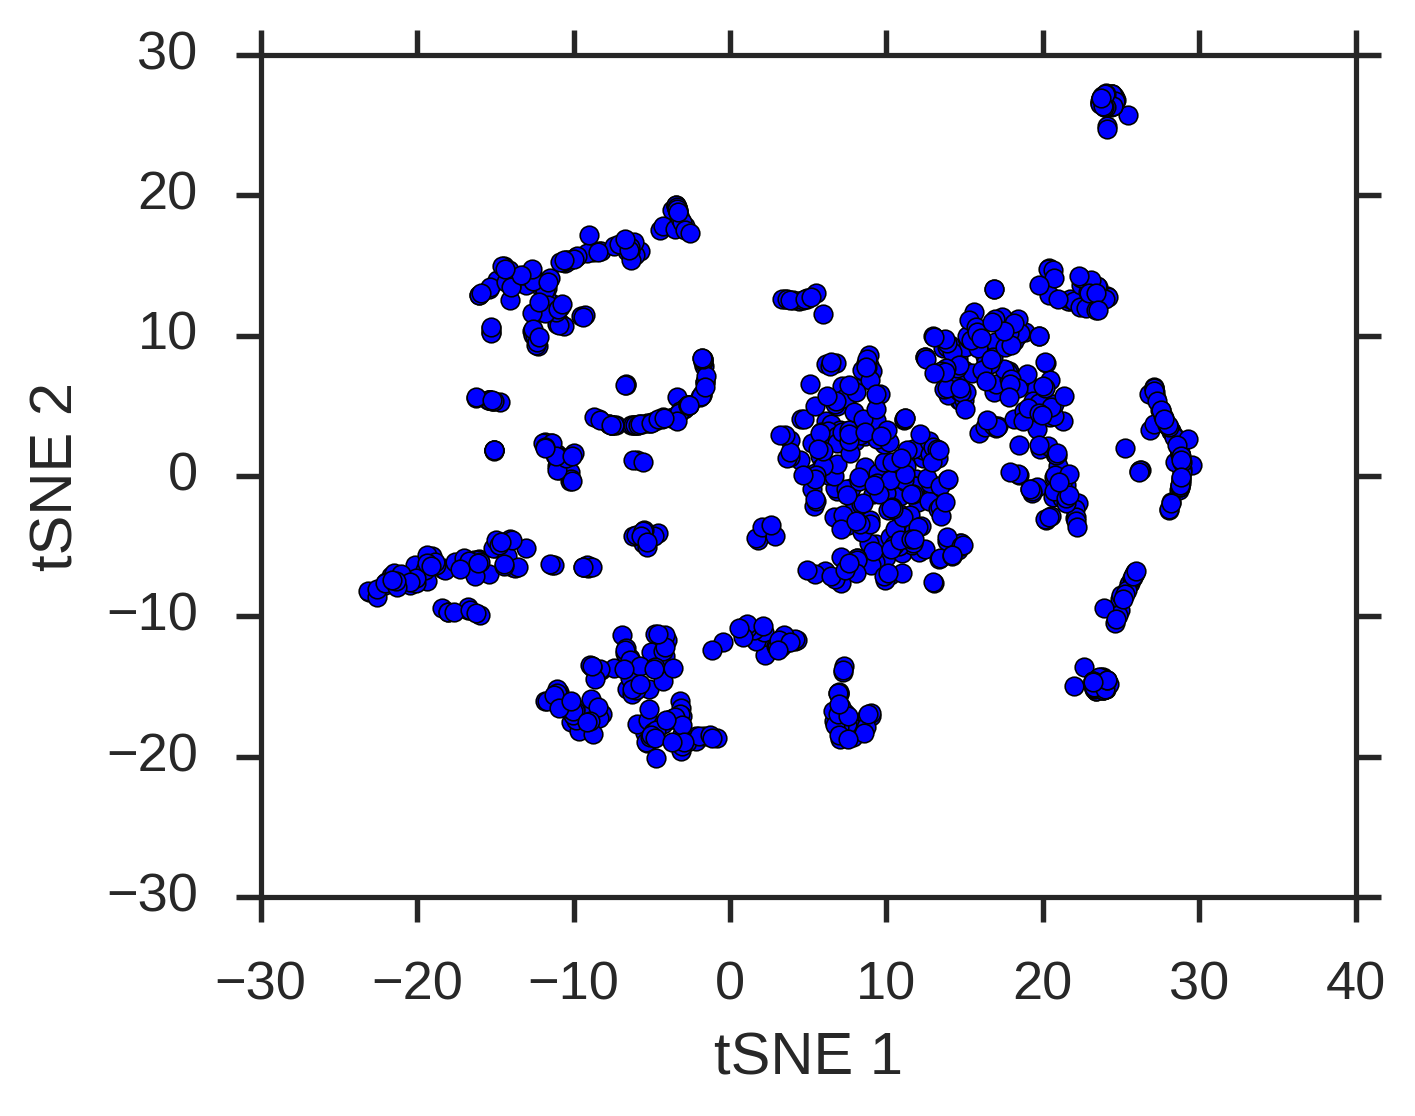

In [17]:
# Note that clustering is different from that shown in paper because random seed is different
# One can tweak the clustering parameters to achieve homogeneity in dynamical profiles
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], s=20, edgecolor="k")
ax.set_xlabel("tSNE 1")
ax.set_ylabel("tSNE 2")
plt.tight_layout()

In [18]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=5).fit(X_TSNE)
labels_HDBSCAN = clusterer.labels_
print "Clusters", max(labels_HDBSCAN)+1

Clusters 14


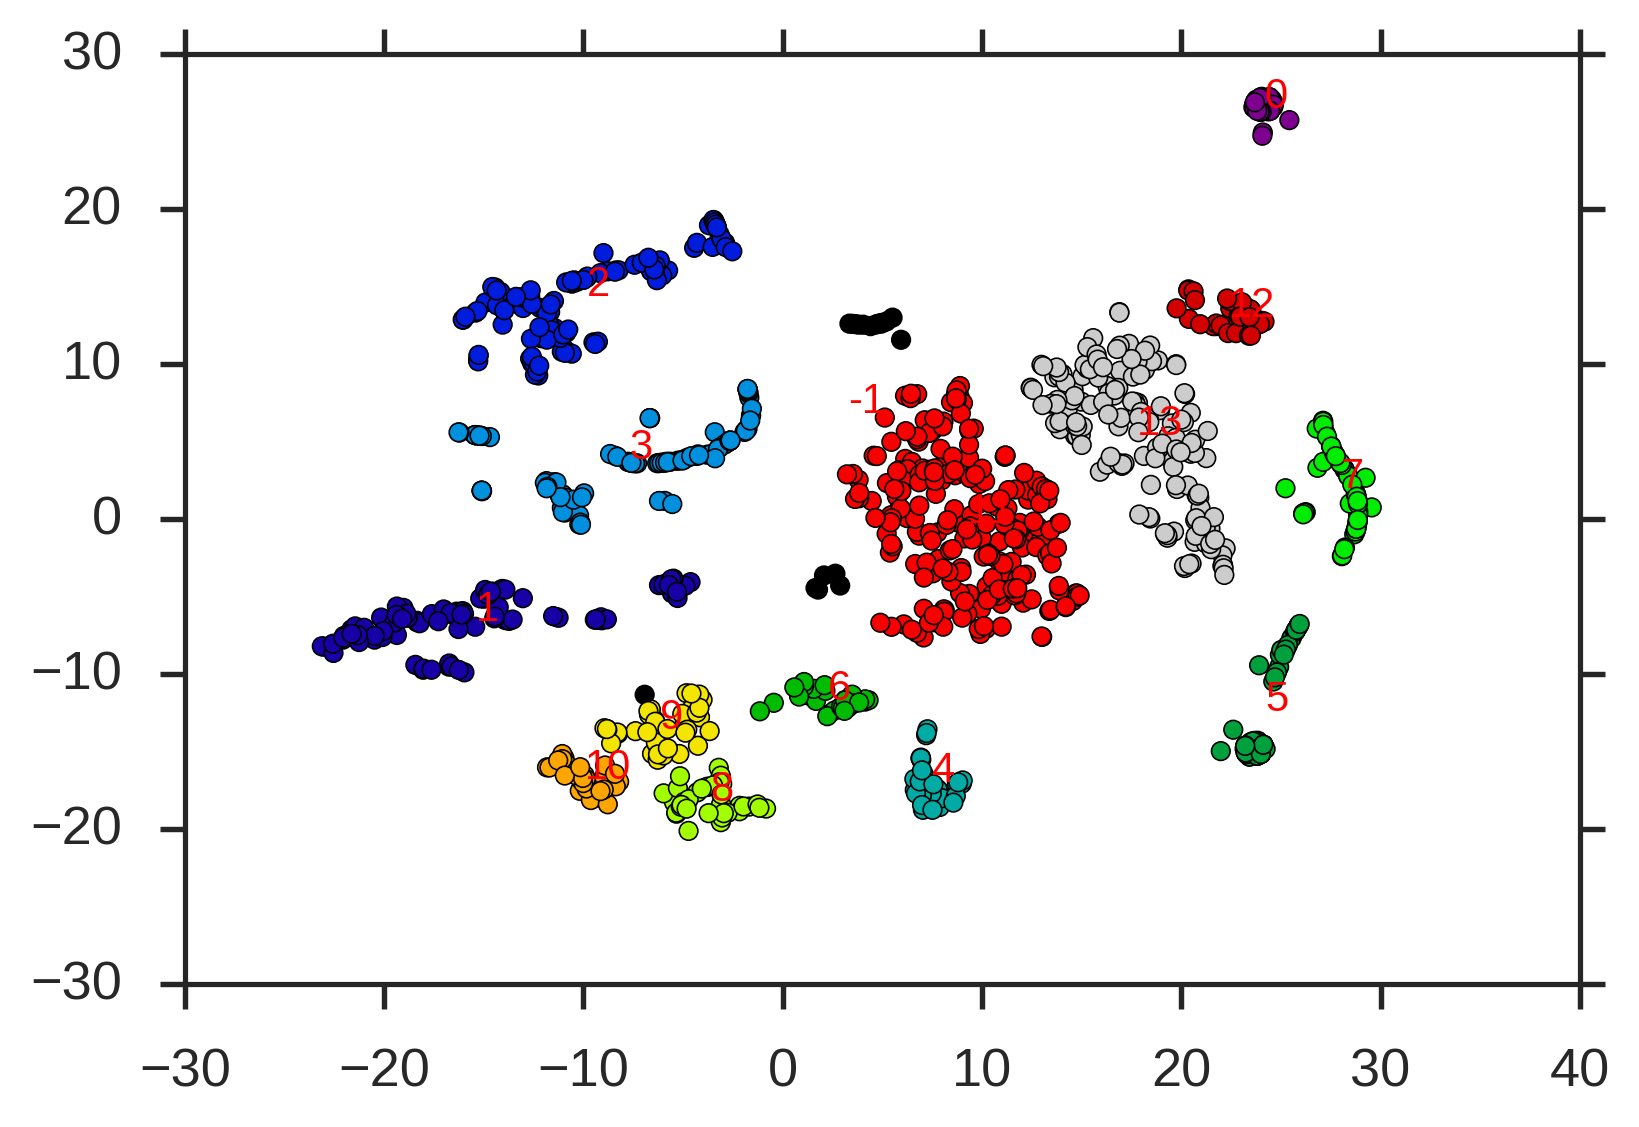

In [19]:
# Plot TSNE with cluster labels
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], c=labels_HDBSCAN, cmap="nipy_spectral")
for label in pd.Series(labels_HDBSCAN).value_counts().index:
    x_bar = np.mean(X_TSNE[labels_HDBSCAN == label, 0])
    y_bar = np.mean(X_TSNE[labels_HDBSCAN == label, 1])
    ax.text(x_bar, y_bar, label, size=10, color="r")

19
32
96
111
106
35
50
29
58
36
40
31
232
32
163


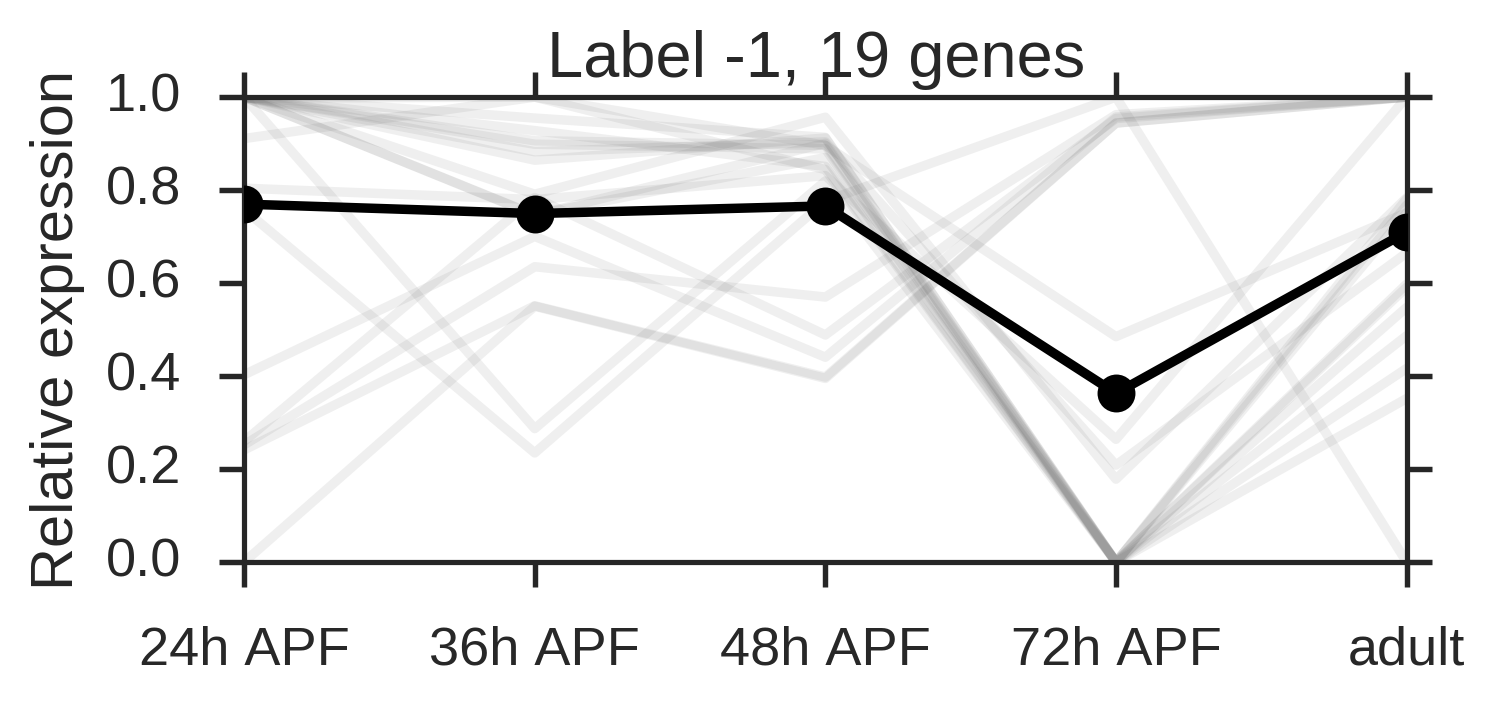

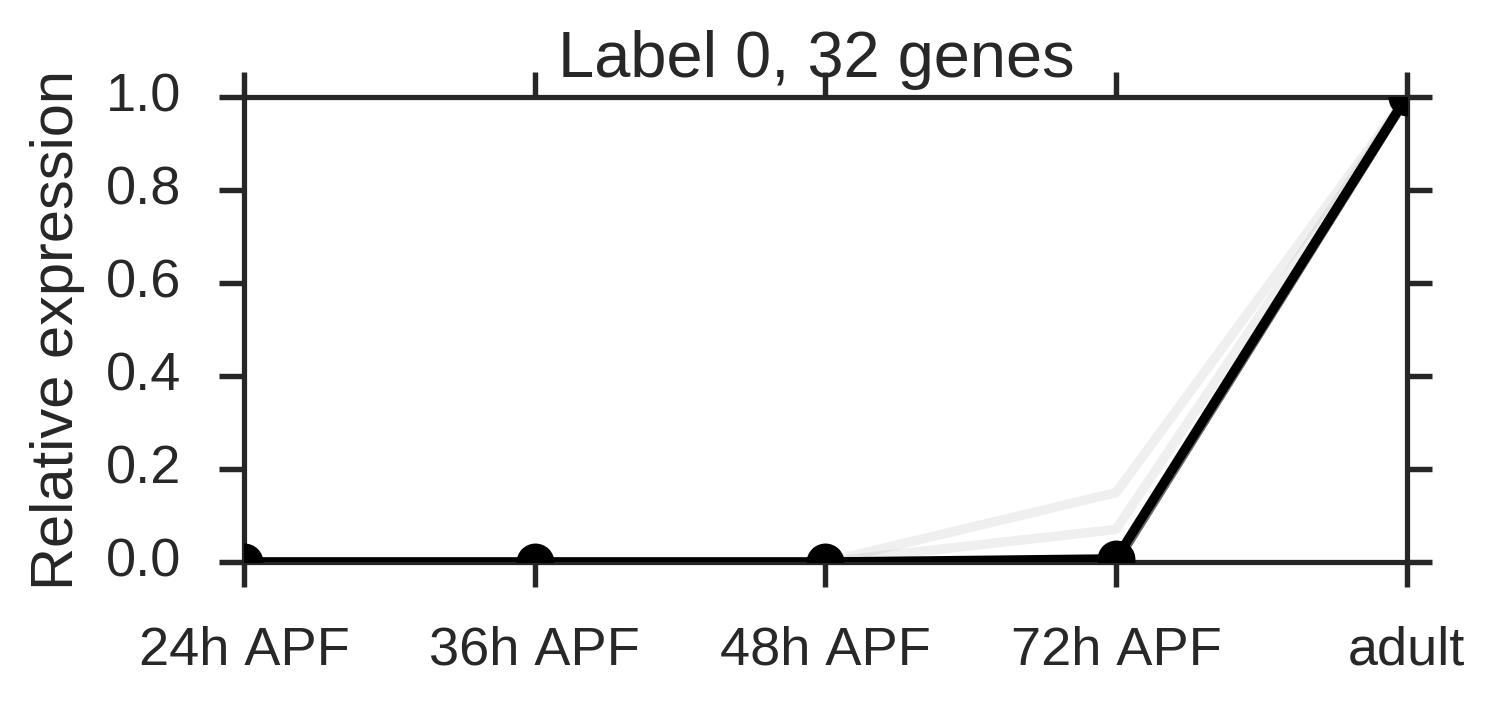

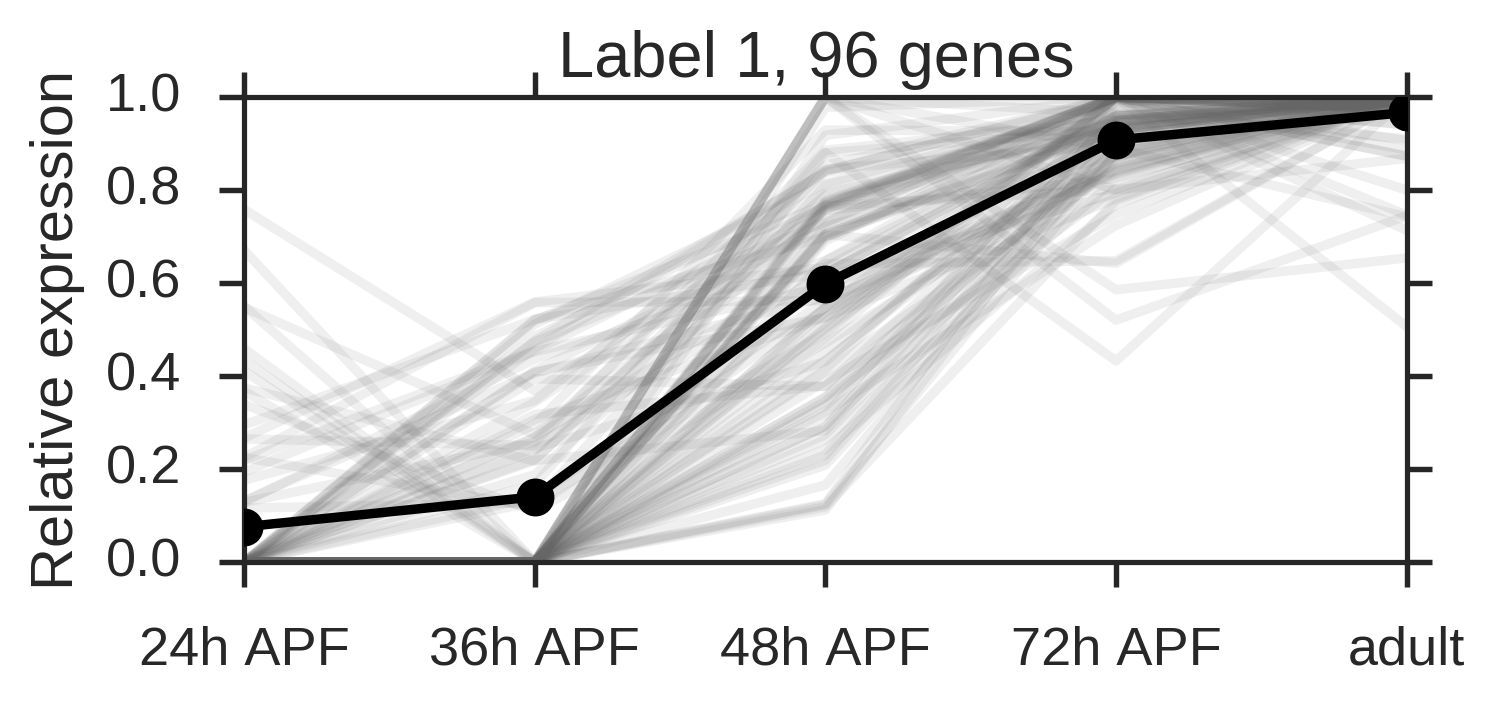

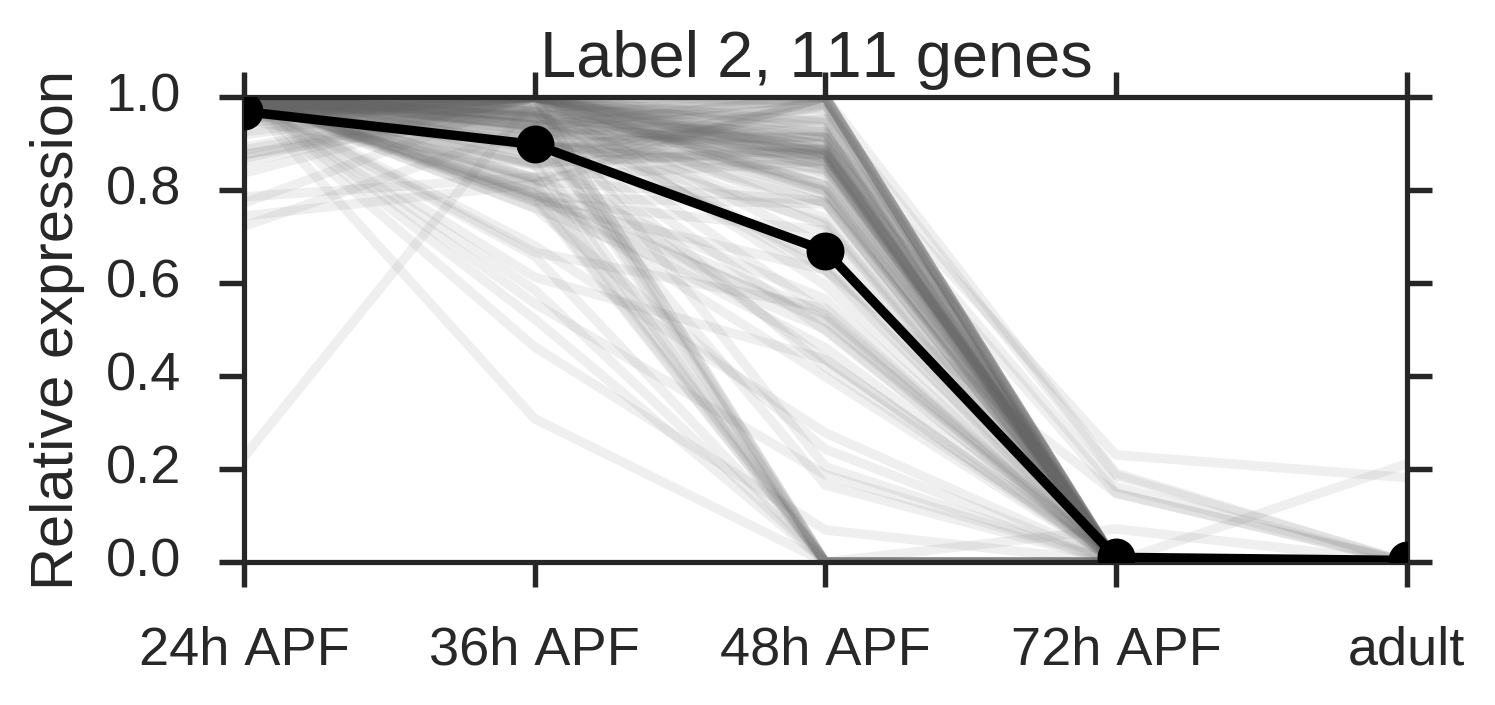

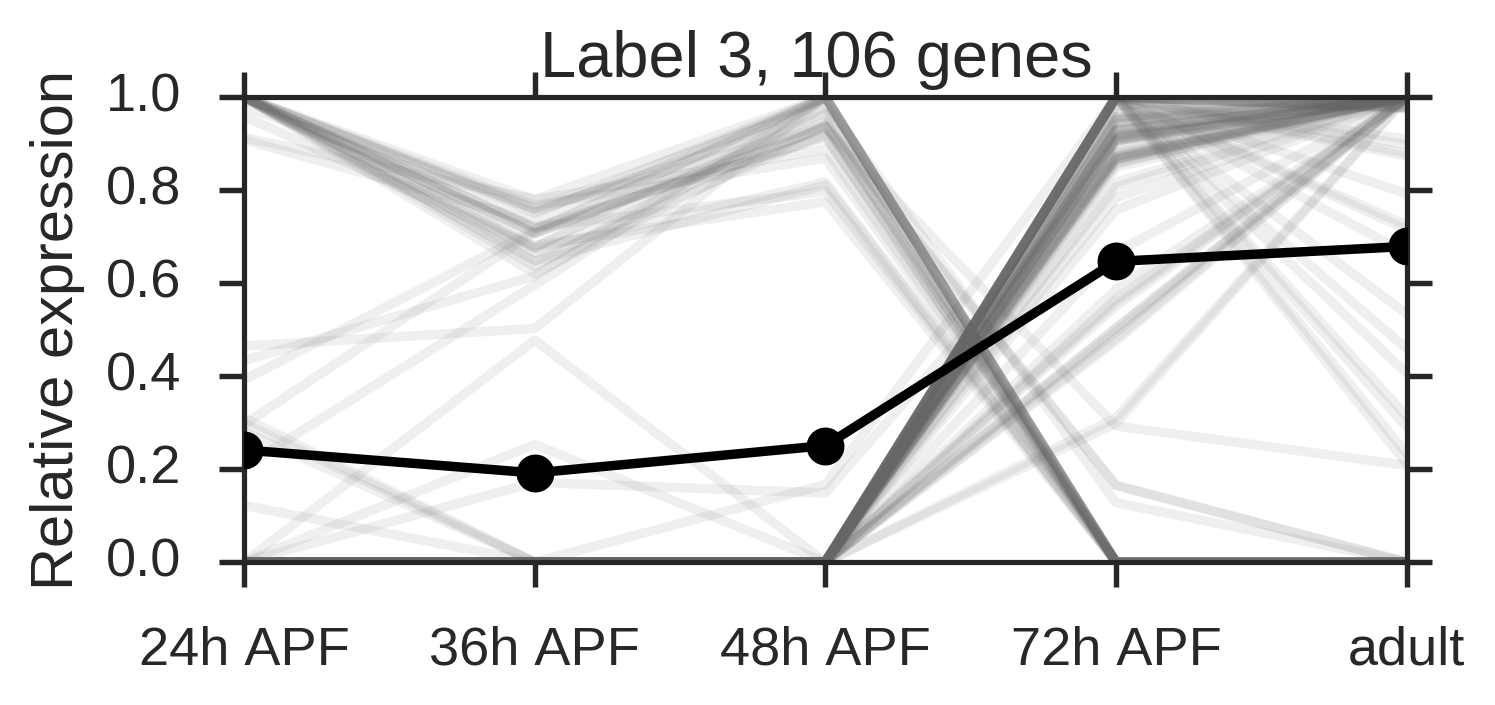

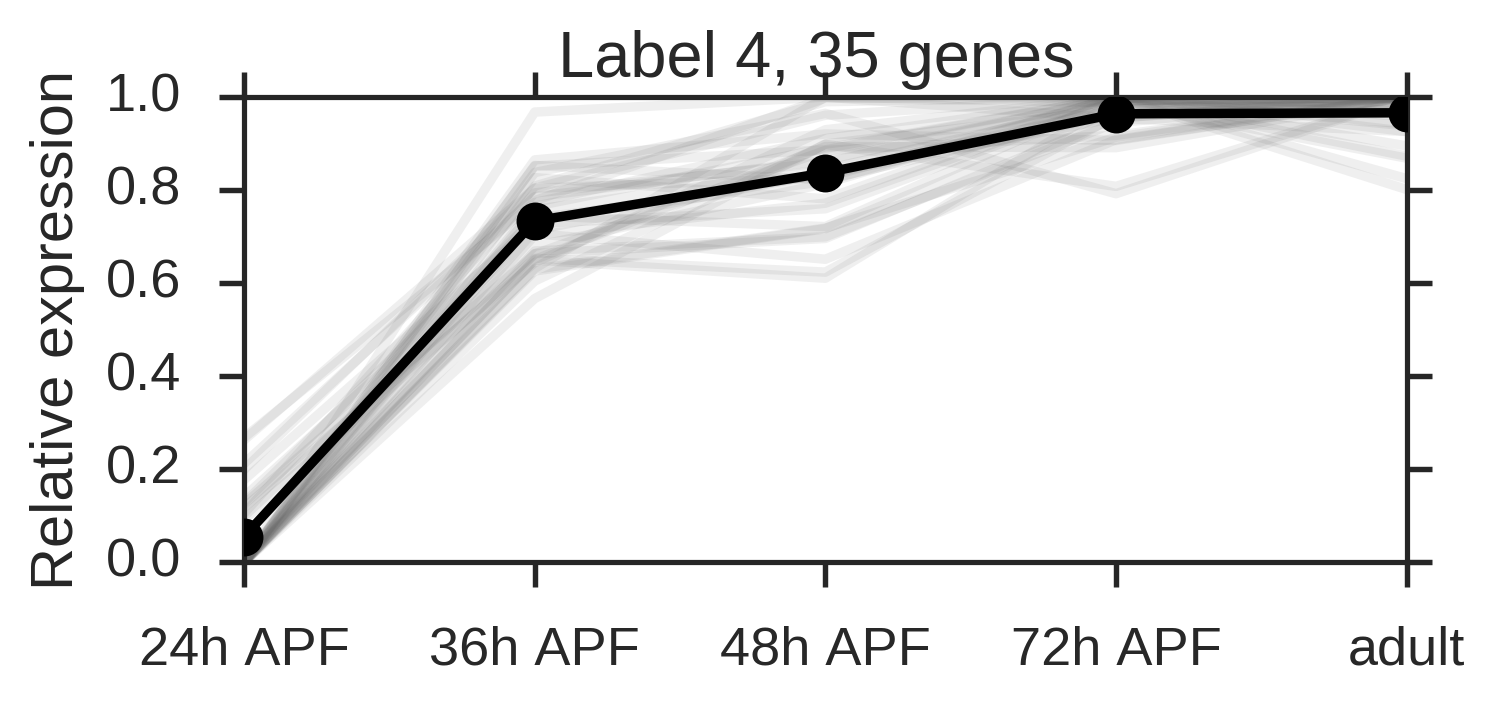

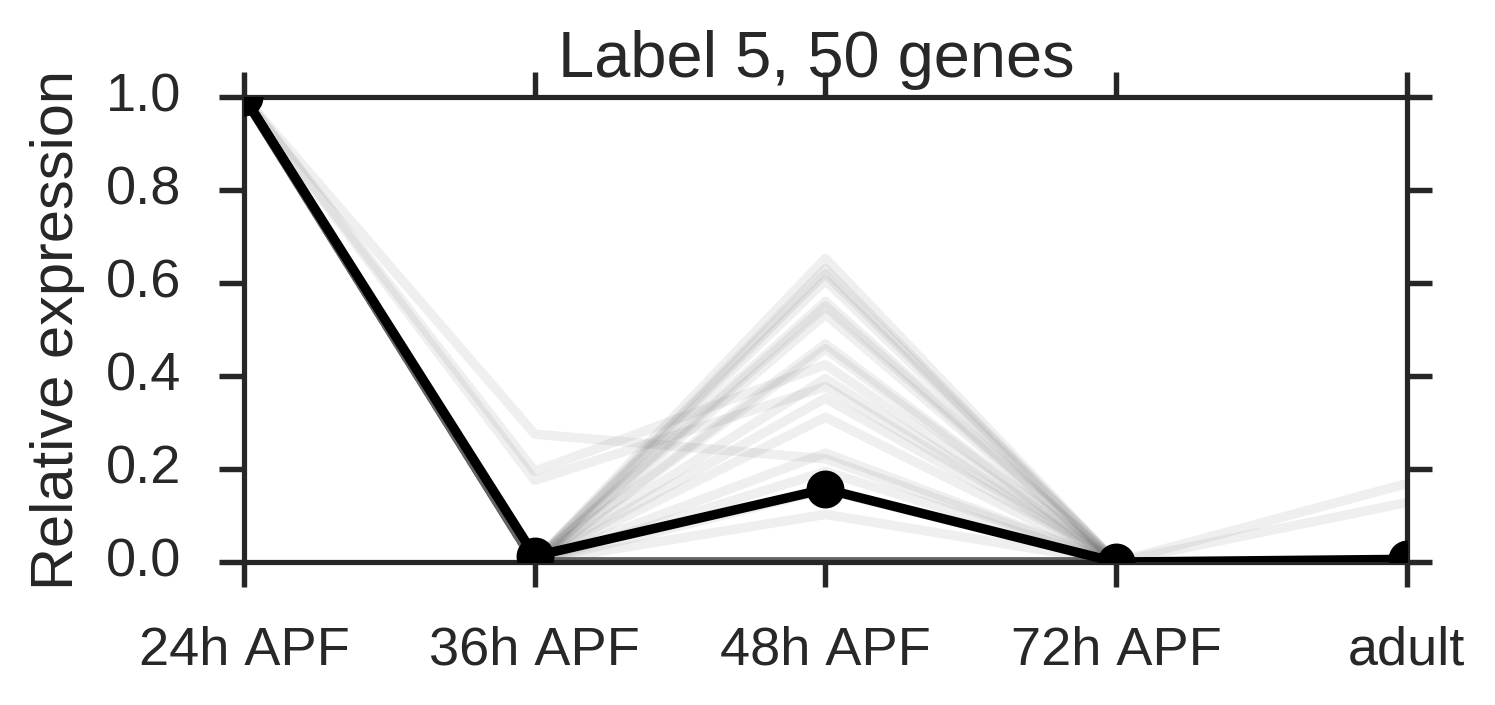

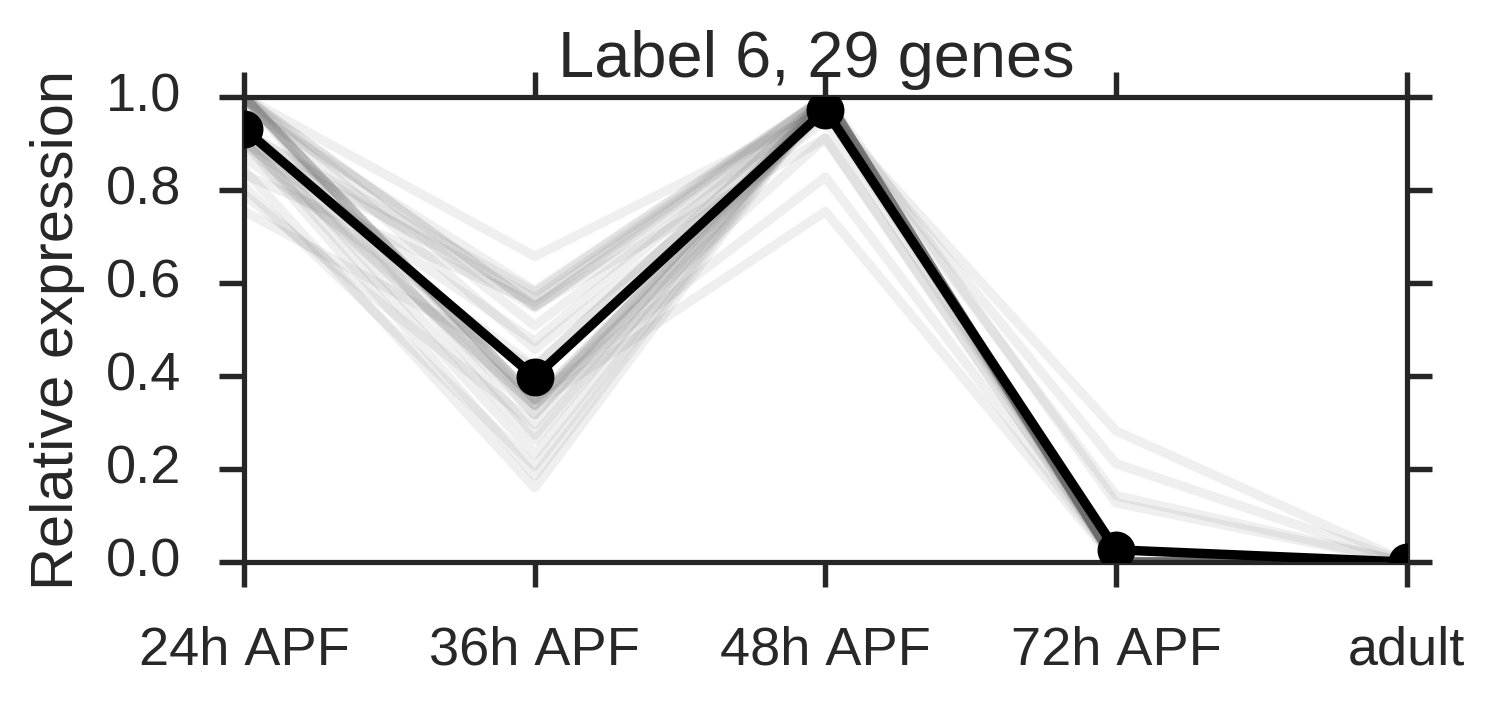

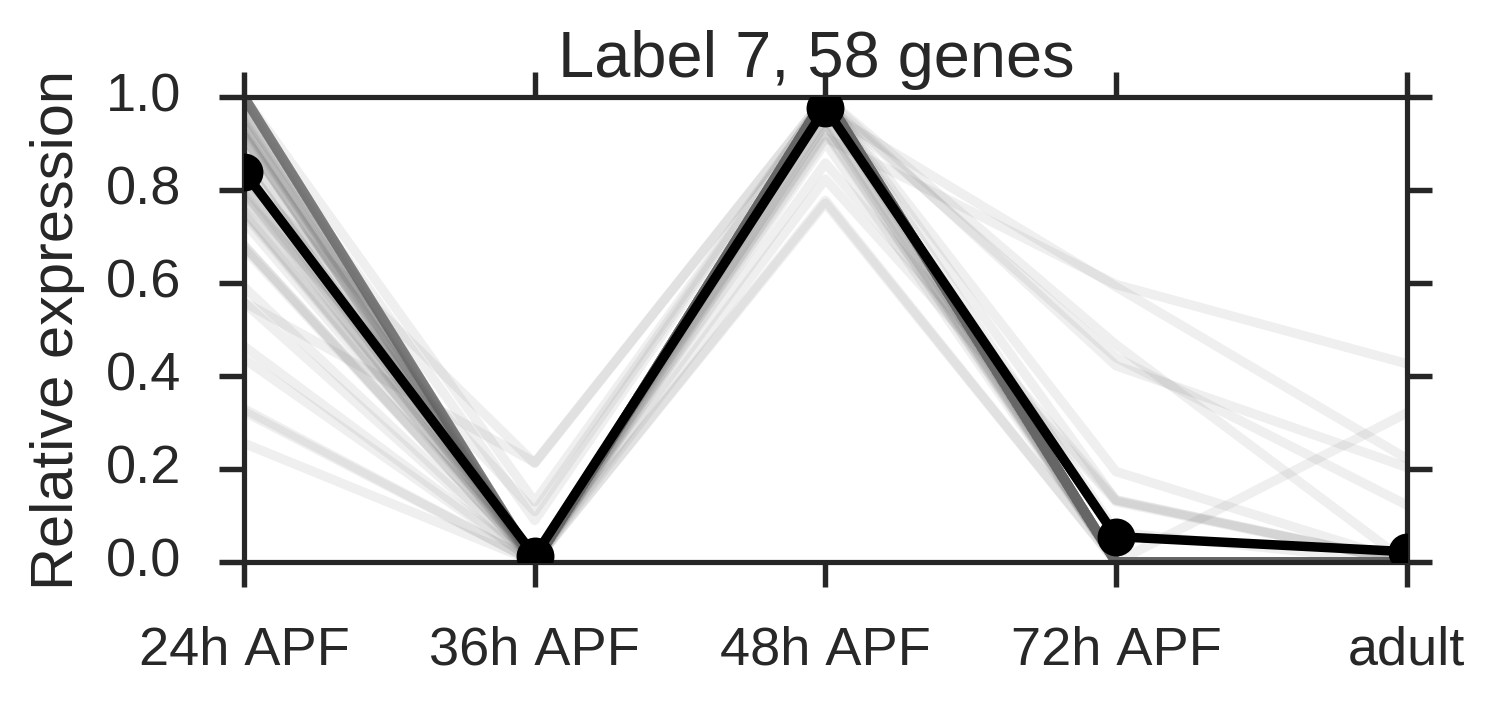

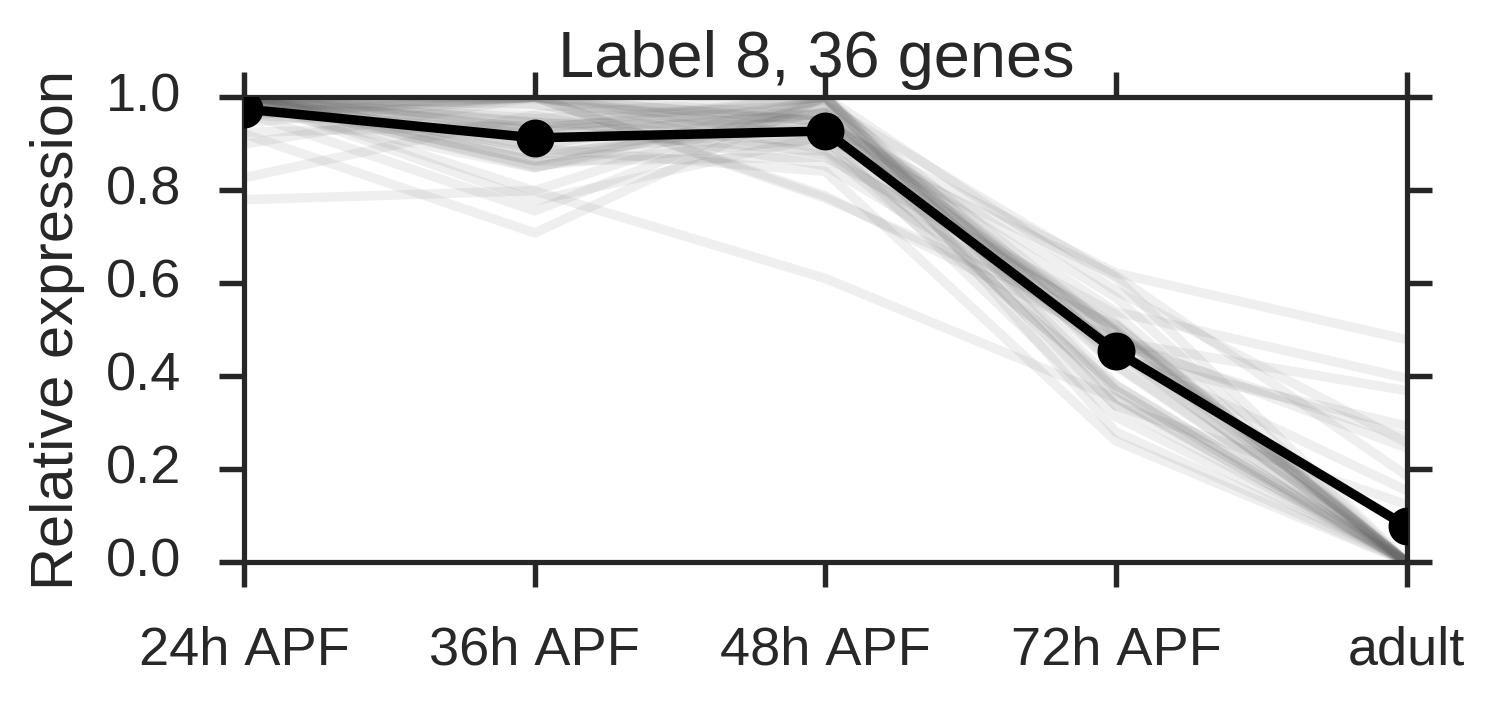

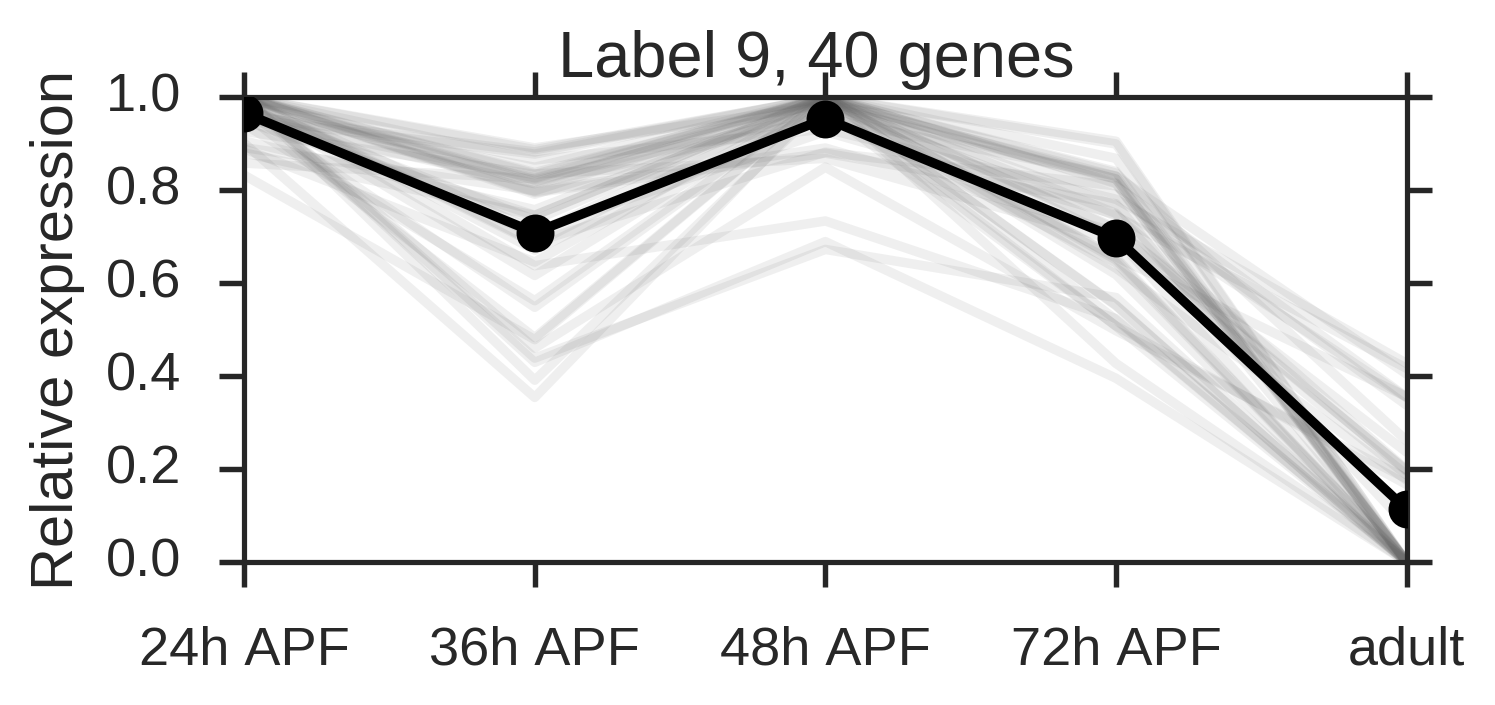

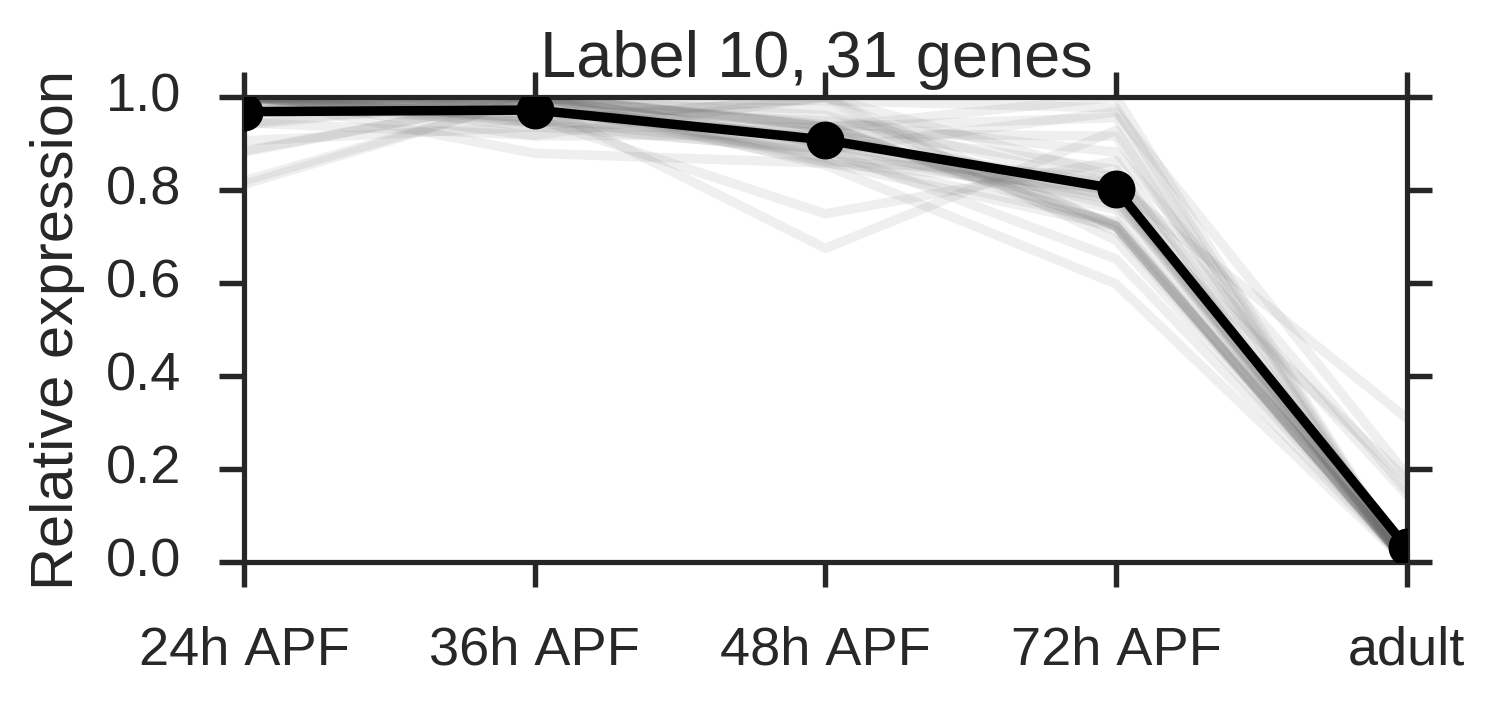

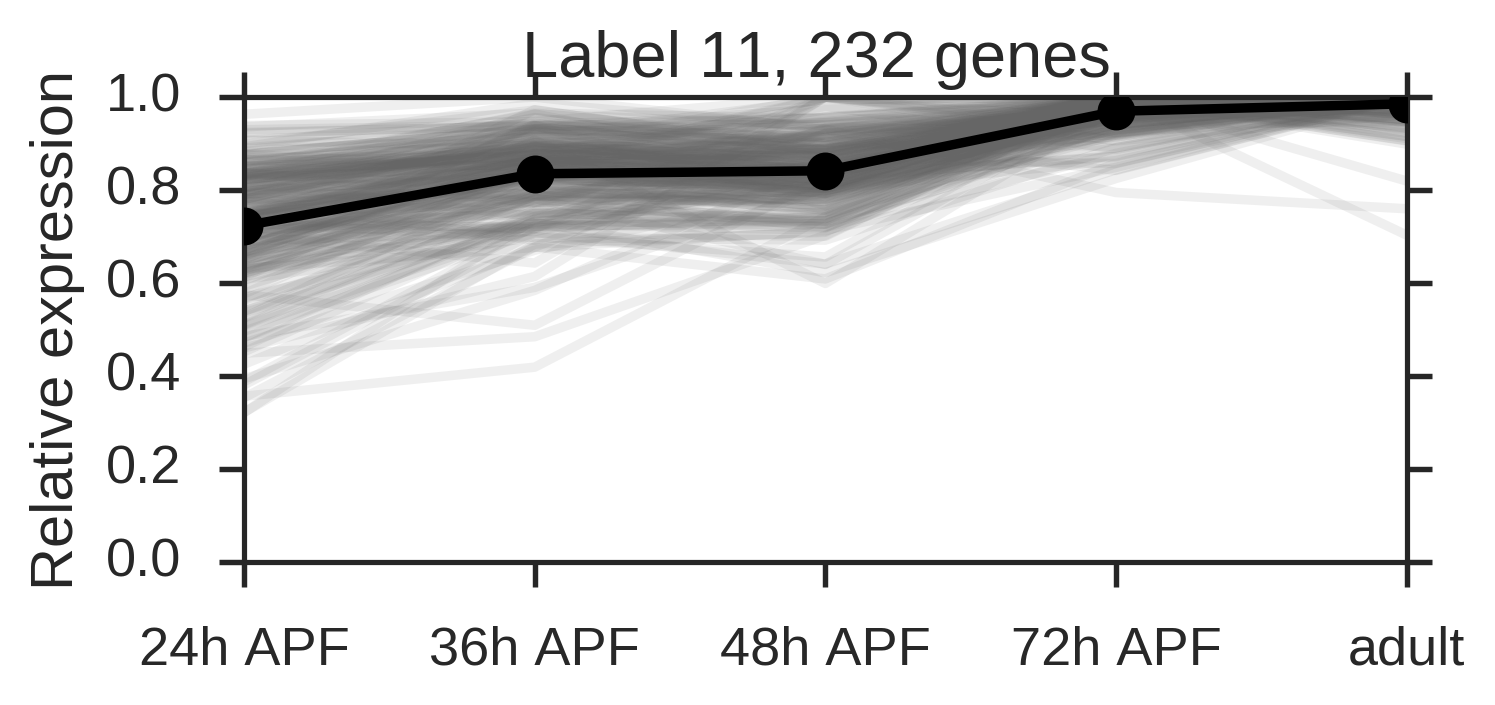

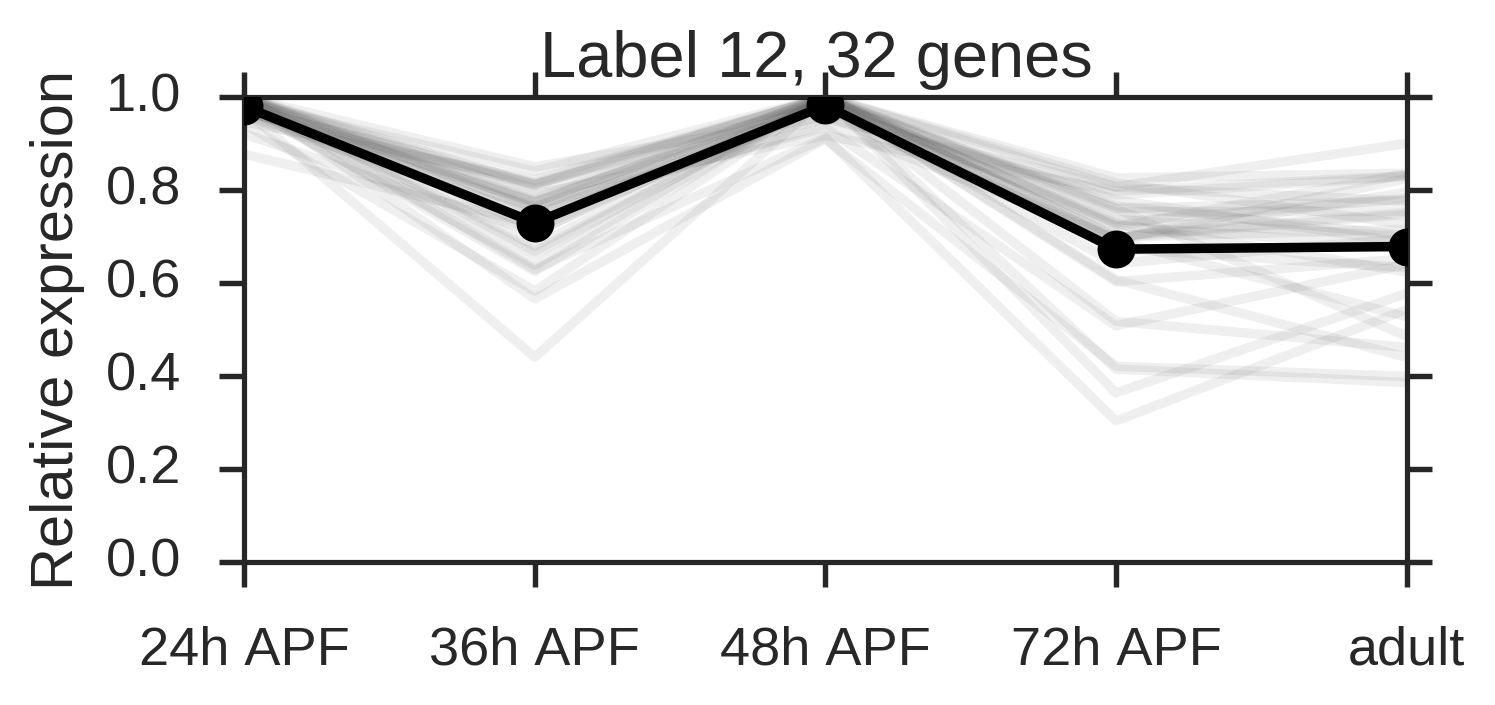

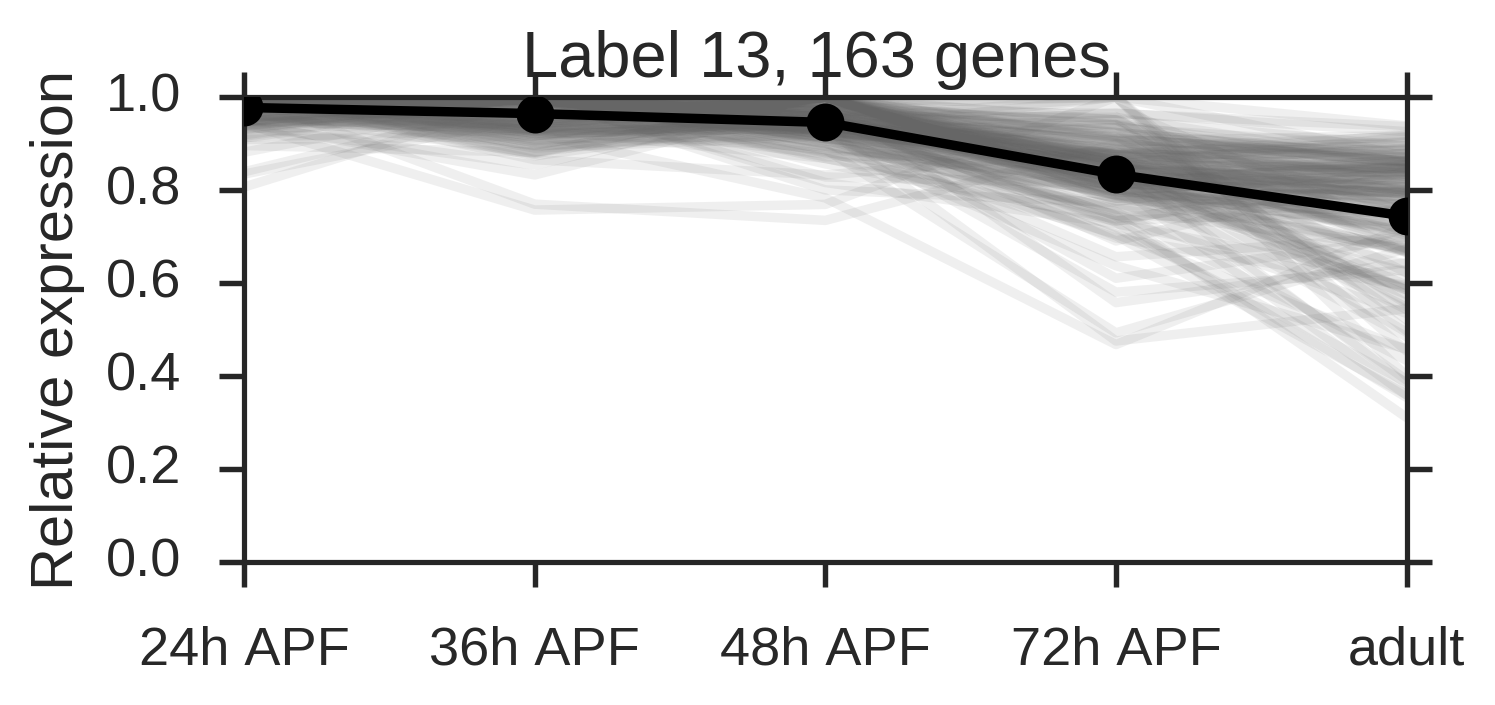

In [24]:
# Plot dynamics of each cluster
for label in range(-1, max(labels_HDBSCAN)+1):
    Y = X.loc[labels_HDBSCAN == label]
    print Y.shape[0]
    
    x = range(5)
    y = np.mean(Y, axis=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(5,2))
    ax.plot(x, y, marker="o", c="k", zorder=20)
    
    for symbol, row in Y.iterrows():
        ax.plot(x, row, alpha=0.1, c="#666666")
    
    ax.set_ylim(0,1)
    ax.set_title("Label " + str(label) + ", " + str(Y.shape[0]) + " genes ")
    ax.set_ylabel("Relative expression")
    ax.set_xticks(x)
    ax.set_xticklabels(["24h APF", "36h APF", "48h APF", "72h APF", "adult"])

In [22]:
# Print TFs in each wave

for label in range(-1, max(labels_HDBSCAN)+1):
    Y = X.loc[labels_HDBSCAN == label]
    print "Wave", label
    try:
        myGenes = list(Y.loc[TFs].dropna().index)
        for x in myGenes:
            print x
    except KeyError:
        print
        continue
    print

Wave -1
CG12071
CG3726

Wave 0
cbt
Hr38
Mef2
Usf

Wave 1
CG8909
Glut4EF
maf-S
mRpL55

Wave 2
CG31460
CG9705
HDAC1
Nlp
Ssrp

Wave 3
Alh
brat
CG4404
CG8216
row
slmo

Wave 4

Wave 5
ADD1
Bap111
Blimp-1
CG15435
CG17803
chm
e(y)2
neur
Sidpn
woc

Wave 6
CG42724
E2f1
jing
MED26

Wave 7
brm
CG12054
CG31510
crp
Gug
hang
lid
MTA1-like
Set1
Top2
trx

Wave 8
Hr4
sd
tgo
XNP

Wave 9
BuGZ
corto
Smox
tup

Wave 10
mod

Wave 11
CG11876
Pdp1

Wave 12
br
chinmo
crol
jim
kis
Msp300
spen
Unr

Wave 13
14-3-3epsilon
14-3-3zeta
cg
CG8108
chn
lola
mamo
mbf1
mirr
Oaz
Pep
pros
RpS3
SF2
Su(var)205
yps



In [23]:
# Print CSMs in each wave

for label in range(-1, max(labels_HDBSCAN)+1):
    Y = X.loc[labels_HDBSCAN == label]
    print "Wave", label
    try:
        myGenes = list(Y.loc[CSMs].dropna().index)
        for x in myGenes:
            print x
    except KeyError:
        print
        continue
    print

Wave -1
CG5758
comm
LRR

Wave 0
CG11099

Wave 1
CG31221
CG44153
CG7381
CG8909
dpr5
Hasp
hig
jeb
mtd

Wave 2
beat-VI
CG31075
cv-2
drl
ergic53
grk
Hs3st-B
LRP1
mgl
Nrk
otk
plum
qsm
sca
Sema-1b
Tl
wit

Wave 3
caps
CG10483
CG12950
CG32432
Ddr
Dscam3
Proc
Ror
Sema-2b

Wave 4
CG33543
dpr9
rgn
Tsp66E

Wave 5
18w
CG17839
CG2247
CG3408
fas
fz2
Nrt

Wave 6
beat-Ic
CG6024
Dscam2
hbs
Nrg
Ptp69D

Wave 7
Dg
ed
fred
kuz
lbk
nrm
Ptp10D

Wave 8
Dscam1
Nrx-IV
tnc
Toll-6

Wave 9
CG4168
CG7166
dpr12
Eph
Sema-1a

Wave 10
Scgalpha
Tsp39D

Wave 11
7B2
CG14762
Fas1
Tsp42Ej

Wave 12
Appl
CadN
CG34380

Wave 13
Ank2
Cals
CG13532
CG15765
CG34370
Cirl
Con
Cow
Fas2
mmd
Sdc
Sema-2a
Ten-a



In [480]:
# # Write genes in each wave to file (for GO analysis)
# for label in range(-1, max(labels_HDBSCAN)+1):
#     Y = X.loc[labels_HDBSCAN == label]
#     outfile = "wave" + str(label) + ".txt"
#     with open(outfile, 'w') as out:
#         for x in list(Y.index):
#             out.write(x + "\n")

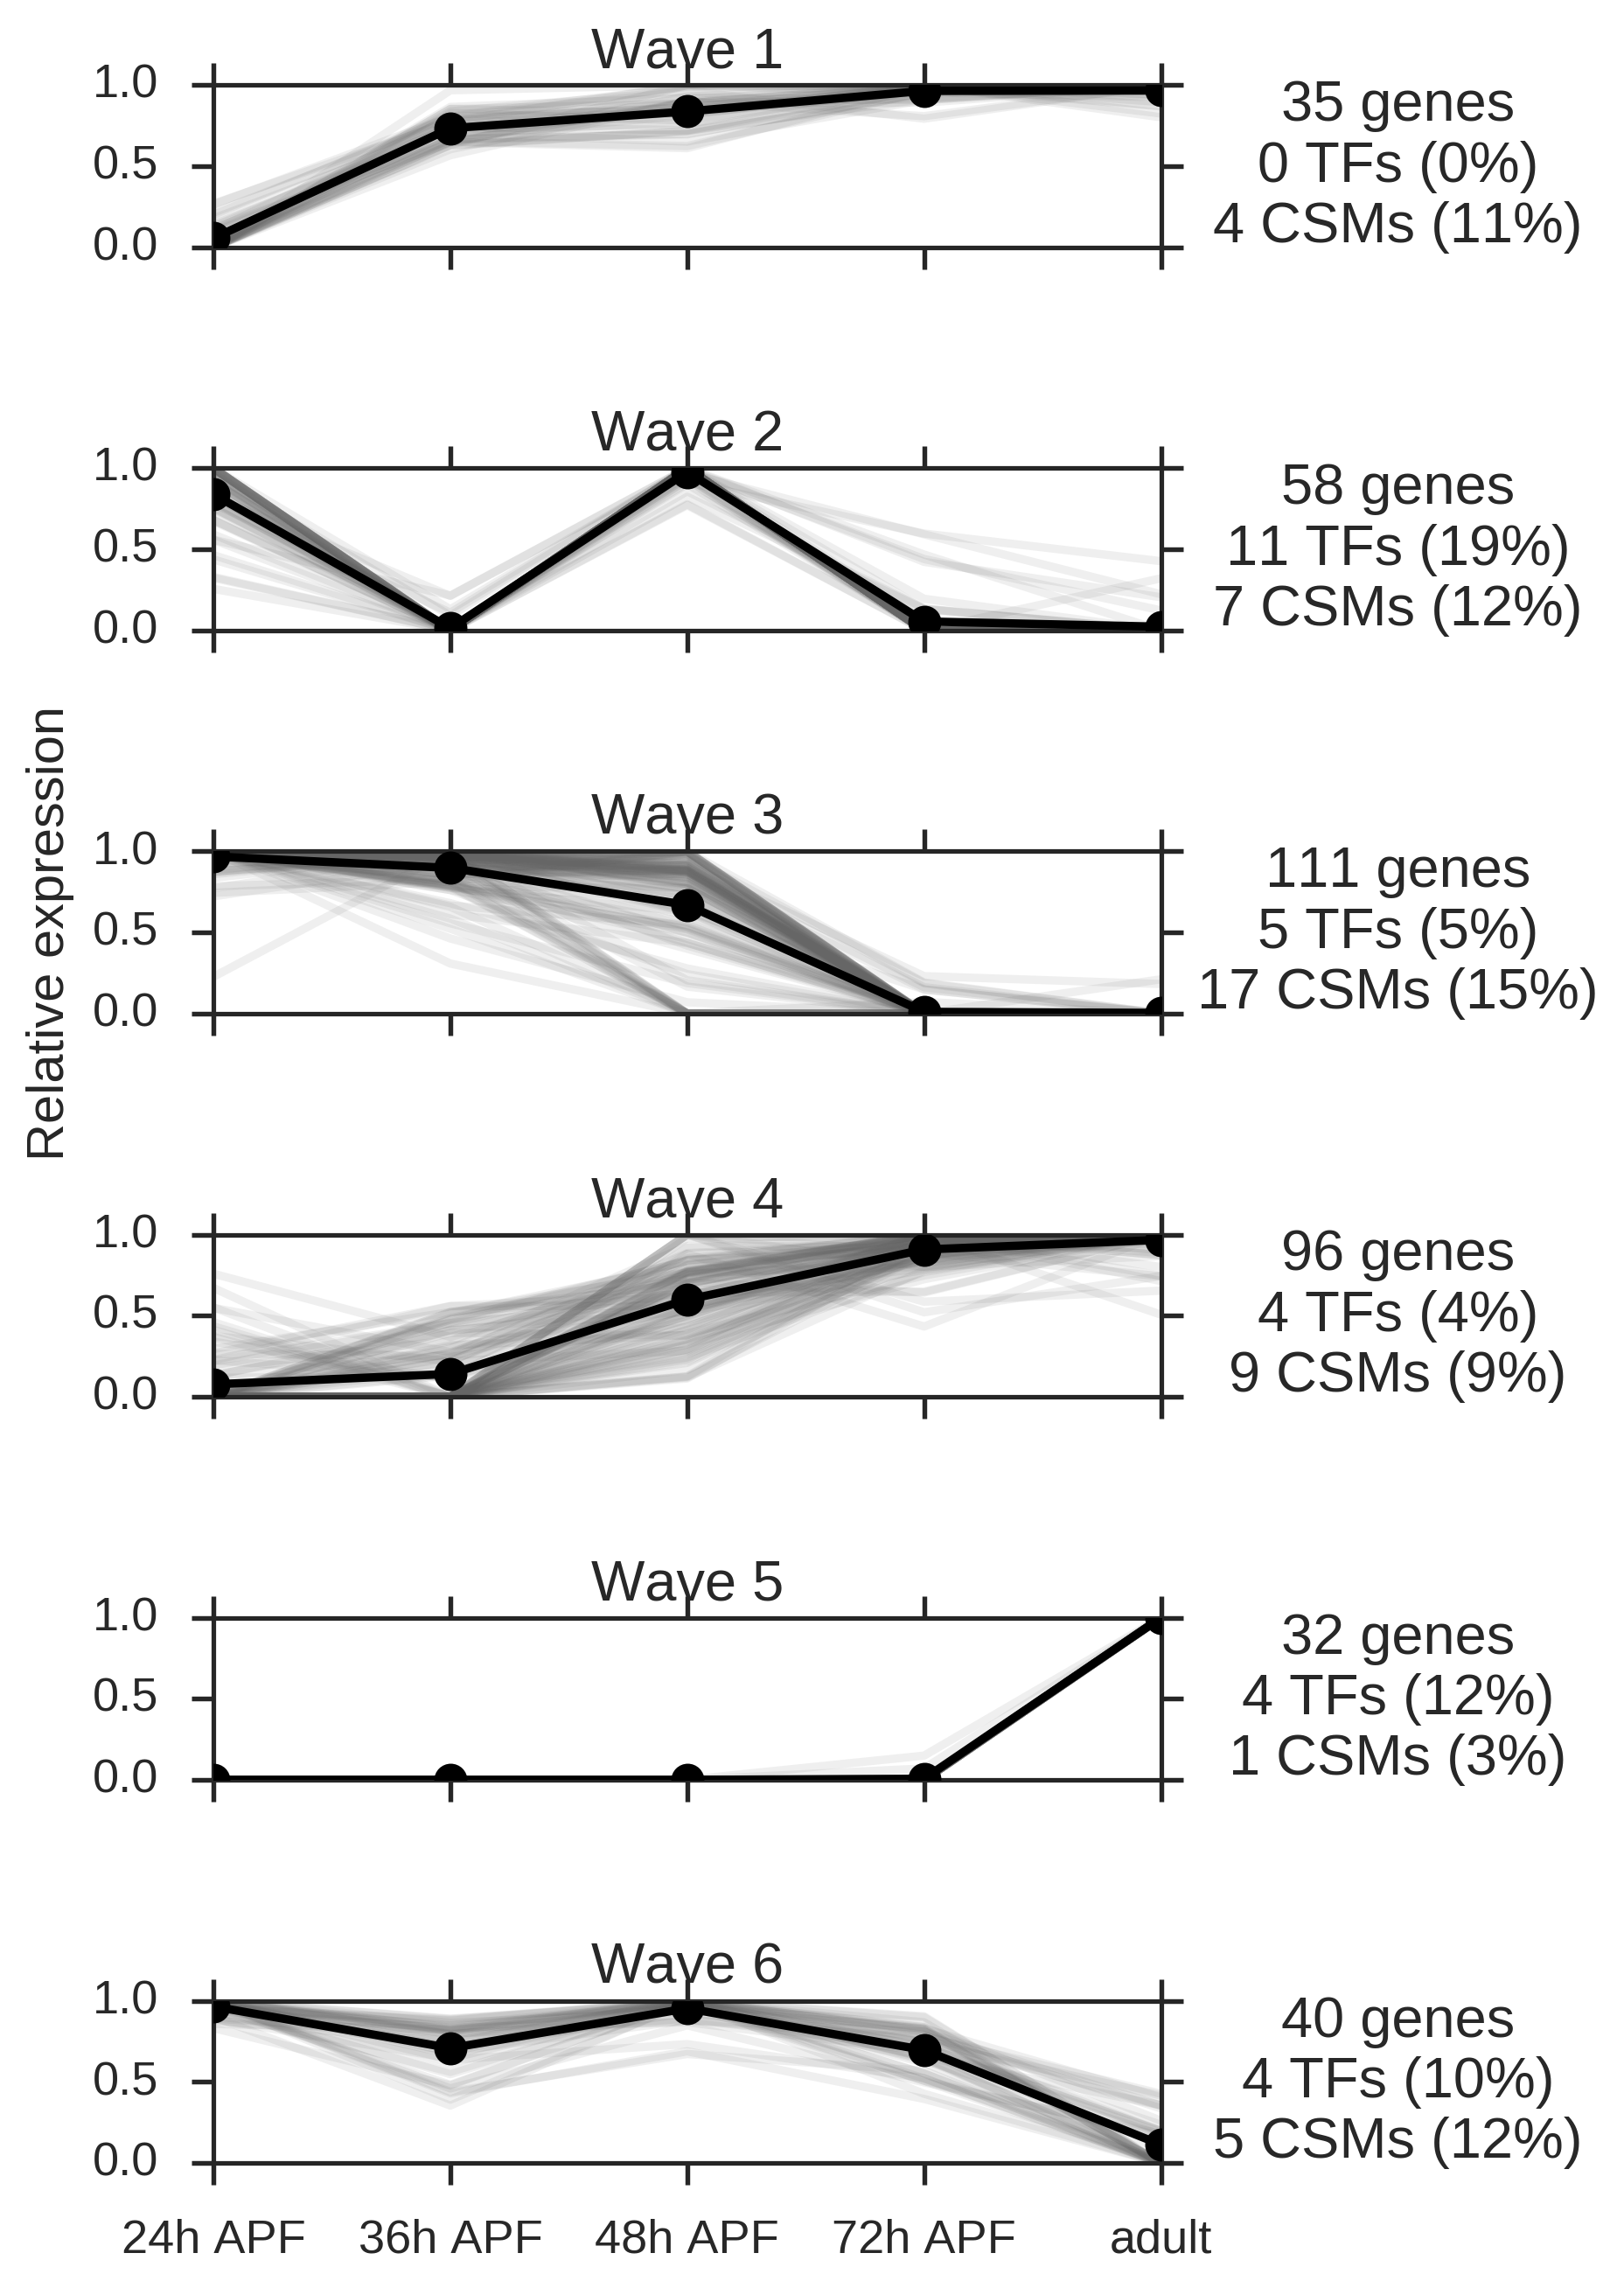

In [20]:
# Plot dynamics of each cluster in a more pretty format and ordered as waves

# Upregulated

labels_ordered = [4, 7, 2, 1, 0, 9]

fig, axes = plt.subplots(len(labels_ordered), 1, figsize=(5,1.5*len(labels_ordered)), sharex=True)

for i, (ax, label) in enumerate(zip(axes, labels_ordered)):
    
    Y = X.loc[labels_HDBSCAN == label]
    num_genes = Y.shape[0]
    
    # Calculate number of TFs and CSMs in wave
    try:
        num_TFs = len(list(Y.loc[TFs].dropna().index))
    except KeyError:
        num_TFs = 0

    try:
        num_CSMs = len(list(Y.loc[CSMs].dropna().index))
    except KeyError:
        num_CSMs = 0
        
    # Plot dynamics
    
    x = range(5)
    y = np.mean(Y, axis=0)
    
    ax.plot(x, y, marker="o", c="k", zorder=20)
    
    for symbol, row in Y.iterrows():
        ax.plot(x, row, alpha=0.1, c="#666666")
    
    ax.set_ylim(0,1)
    # title = "Wave " + str(label) + ", " + str(Y.shape[0]) + " genes, " + str(num_TFs) + " TFs, " + str(num_CSMs) + " CSMs"
    title = "Wave " + str(i+1)
    ax.set_title(title)
    
    frac_TFs = float(num_TFs)/float(Y.shape[0])
    frac_CSMs = float(num_CSMs)/float(Y.shape[0])
    annotation = '{:d} genes\n{:d} TFs ({:.0f}%)\n{:d} CSMs ({:.0f}%)'.format(num_genes, num_TFs, frac_TFs*100, num_CSMs, frac_CSMs*100)
    ax.text(5, 0.5, annotation, ha="center", va="center")
    
    ax.set_yticks([0, 0.5, 1])
    
axes[2].set_ylabel("Relative expression")    
ax.set_xticks(x)
ax.set_xticklabels(["24h APF", "36h APF", "48h APF", "72h APF", "adult"])
plt.tight_layout()

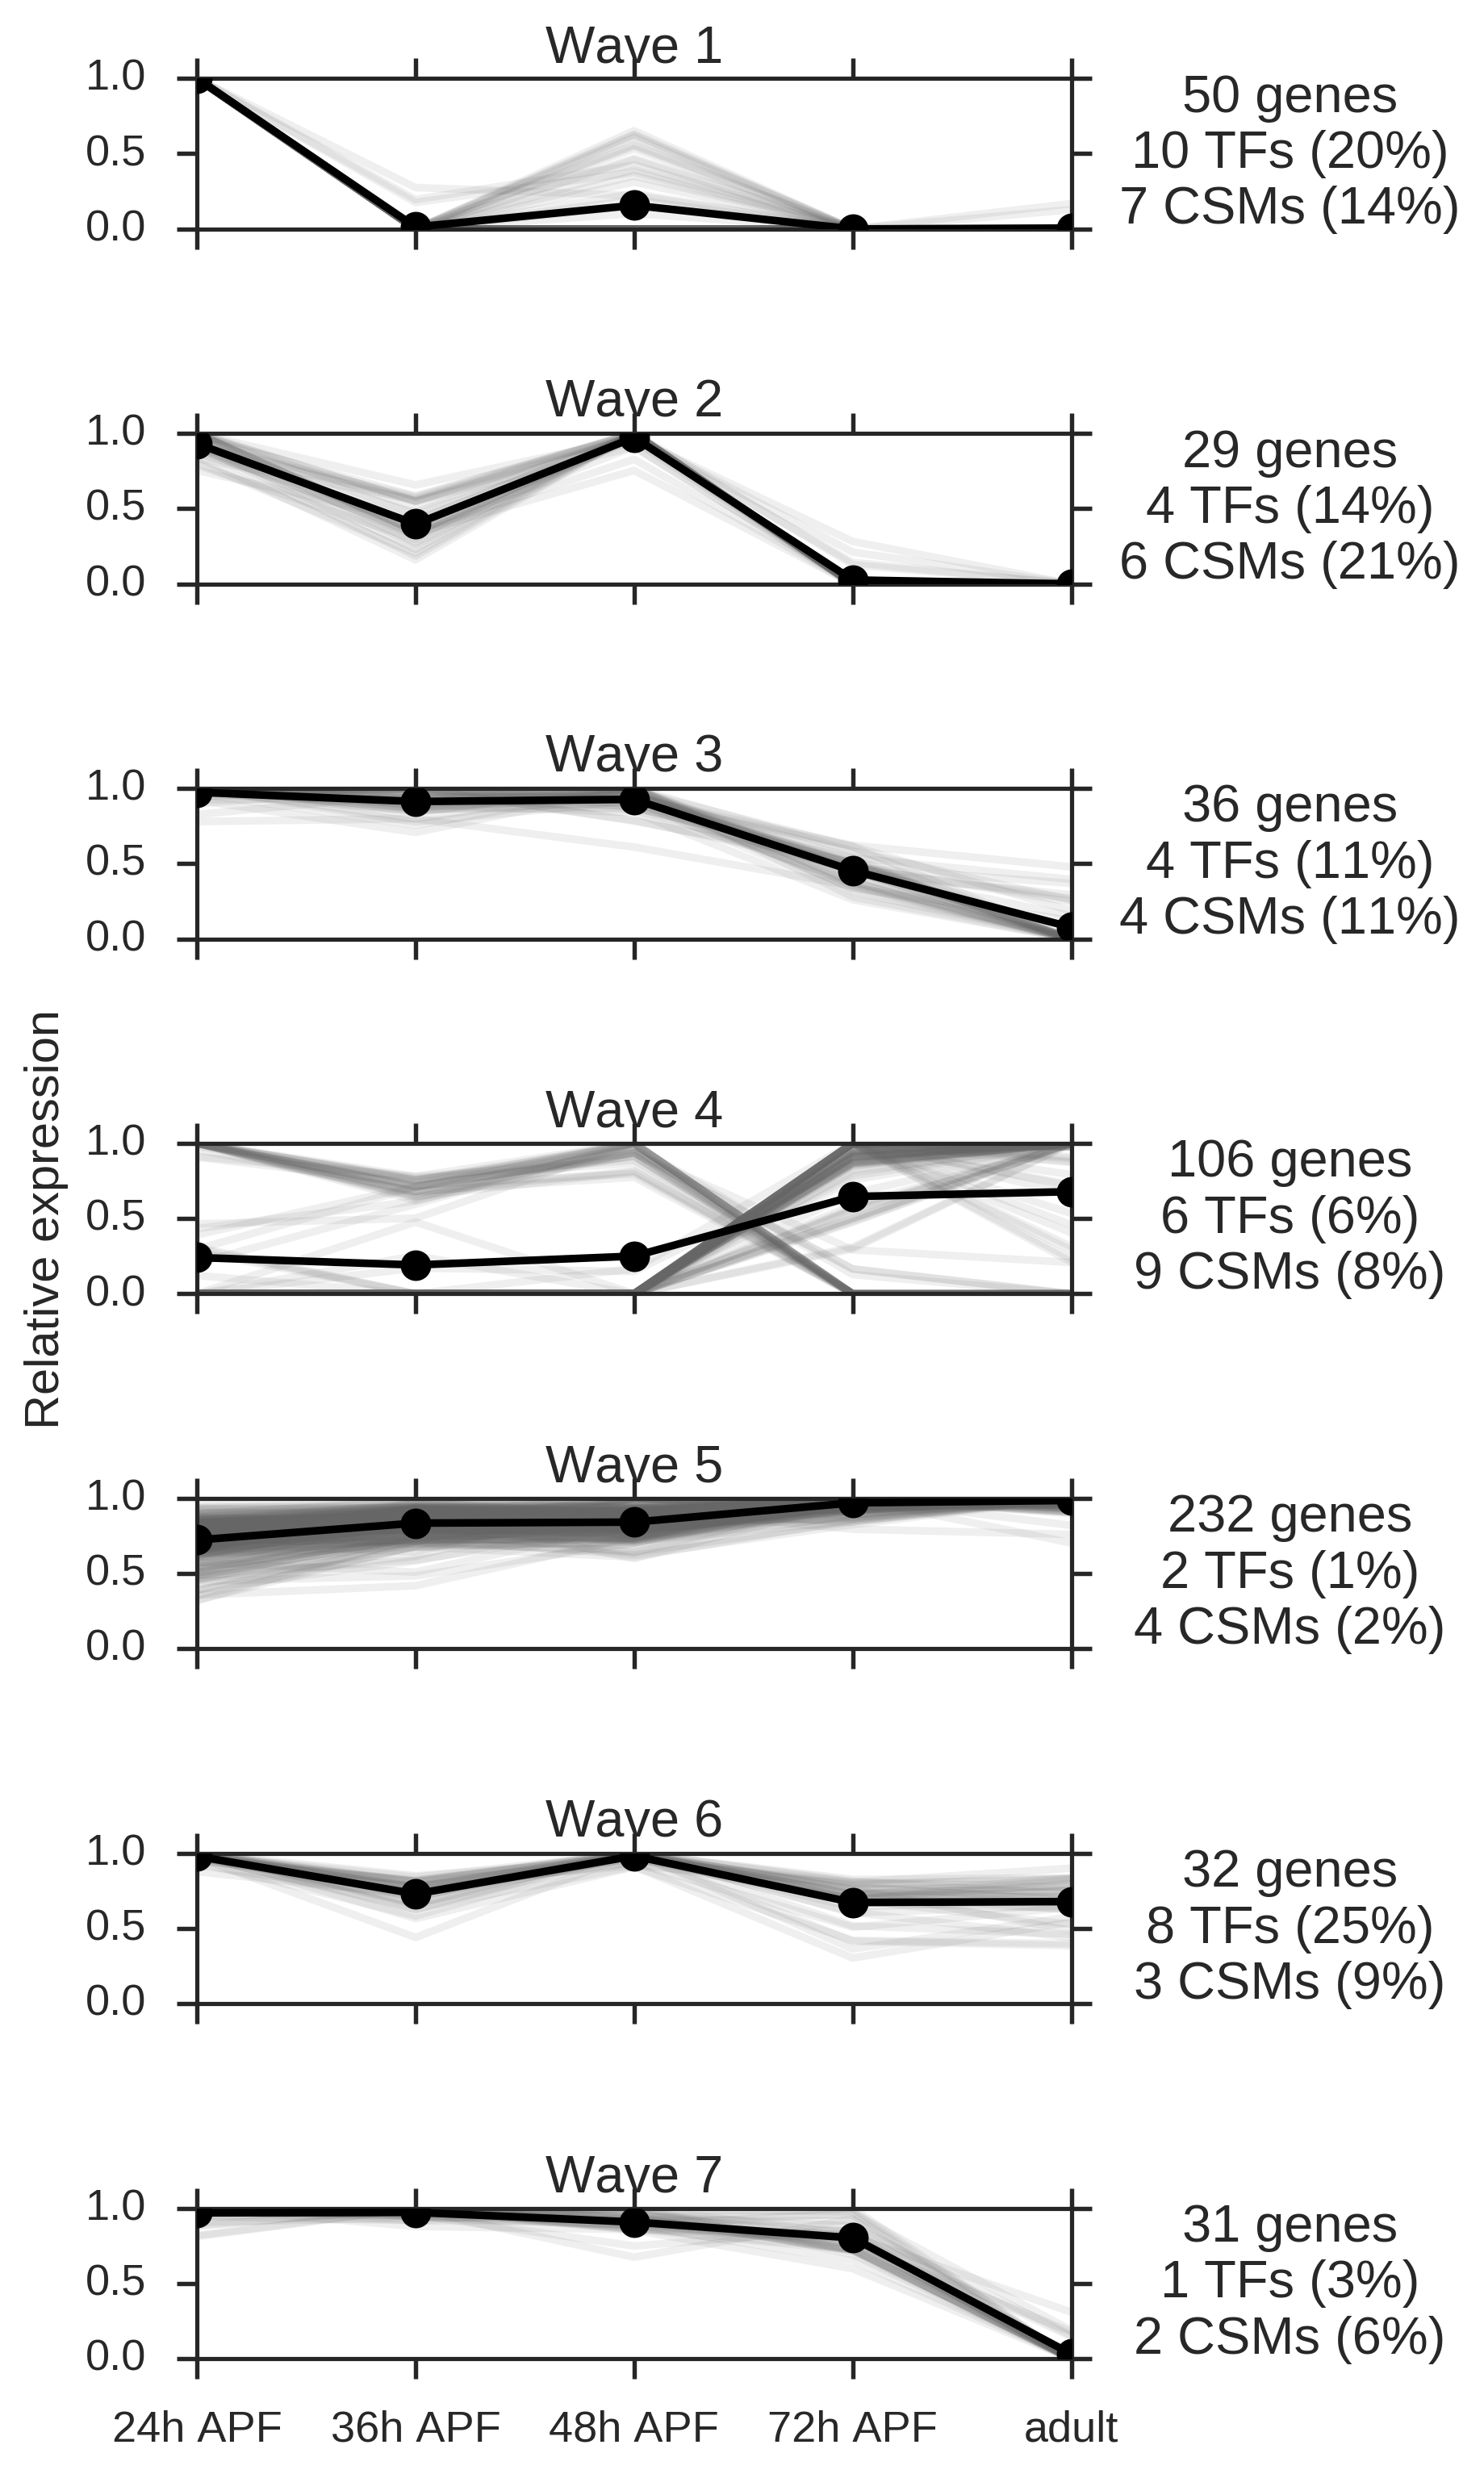

In [21]:
# Downregulated

labels_ordered = [5, 6, 8, 3, 11, 12, 10]

fig, axes = plt.subplots(len(labels_ordered), 1, figsize=(5,1.5*len(labels_ordered)), sharex=True)

for i, (ax, label) in enumerate(zip(axes, labels_ordered)):
    
    Y = X.loc[labels_HDBSCAN == label]
    num_genes = Y.shape[0]
    
    # Calculate number of TFs and CSMs in wave
    try:
        num_TFs = len(list(Y.loc[TFs].dropna().index))
    except KeyError:
        num_TFs = 0

    try:
        num_CSMs = len(list(Y.loc[CSMs].dropna().index))
    except KeyError:
        num_CSMs = 0
        
    # Plot dynamics
    
    x = range(5)
    y = np.mean(Y, axis=0)
    
    ax.plot(x, y, marker="o", c="k", zorder=20)
    
    for symbol, row in Y.iterrows():
        ax.plot(x, row, alpha=0.1, c="#666666")
    
    ax.set_ylim(0,1)
    # title = "Wave " + str(label) + ", " + str(Y.shape[0]) + " genes, " + str(num_TFs) + " TFs, " + str(num_CSMs) + " CSMs"
    title = "Wave " + str(i+1)
    ax.set_title(title)
    
    frac_TFs = float(num_TFs)/float(Y.shape[0])
    frac_CSMs = float(num_CSMs)/float(Y.shape[0])
    annotation = '{:d} genes\n{:d} TFs ({:.0f}%)\n{:d} CSMs ({:.0f}%)'.format(num_genes, num_TFs, frac_TFs*100, num_CSMs, frac_CSMs*100)
    ax.text(5, 0.5, annotation, ha="center", va="center")
    
    ax.set_yticks([0, 0.5, 1])
    
axes[3].set_ylabel("Relative expression")    
ax.set_xticks(x)
ax.set_xticklabels(["24h APF", "36h APF", "48h APF", "72h APF", "adult"])
plt.tight_layout()